## Tarea 2 Conteo aproximado con MCMC aplicado a los modelos Hard-Core y q-coloraciones

En esta tarea se explora el método MCMC para realizar conteos aproximados de las configuraciones factibles en Hardcore y
las q-coloraciones posibles en un grafo. Ambos en grafos $KxK$.

### Conteo aproximado q-coloraciones

### Conteo aproximado config factibles hard-core

In [2]:
import copy
import numpy as np

import utils.gibbs_sampler as gs

In [3]:
K = 4
n_vertices = K * K

# Initialize empty adjacency matrix (K*K) x (K*K)
adjacency_matrix = np.zeros((n_vertices, n_vertices), dtype=int)

# Initialize grid 
current_grid = np.zeros((K, K), dtype=int)

# Storage for results
ratios = []
all_samples = []  # Store samples for each iteration
current_samples = []

# Parameters
convergence_steps = 100000
num_samples = 10000

print("Starting workflow: Building adjacency matrix edge by edge")
print(f"K = {K}, Total vertices = {n_vertices}")
print(f"Convergence steps: {convergence_steps}, Samples per iteration: {num_samples}\n")

# Initialize missing edges set (will be calculated on first call)
missing_edges_set = None
iteration = 0

while True:
    print(f"\n=== Iteration {iteration} ===")
    print(f"Current adjacency matrix has {np.sum(adjacency_matrix) // 2} edges (undirected)")
    
    # Step 1: convergence phase
    print(f"Running {convergence_steps} convergence steps...")
    next_vertex_idx = 0
    for _ in range(convergence_steps):
        current_grid, next_vertex_idx = gs.run_gibbs_hc_order_adjacency(current_grid, K, adjacency_matrix, next_vertex_idx)
    
    # Step 2: Sampling phase - collect 10000 samples
    print(f"Collecting {num_samples} samples...")
    next_vertex_idx = 0
    current_samples = []
    for _ in range(num_samples):
        current_grid, next_vertex_idx = gs.run_gibbs_hc_order_adjacency(current_grid, K, adjacency_matrix, next_vertex_idx)
        current_samples.append(current_grid.copy())
    
    all_samples.append(current_samples.copy())
    print(f"Collected {len(current_samples)} samples")
    
    # Step 3: Add one edge to adjacency matrix
    print("Adding one edge to adjacency matrix...")
    adjacency_matrix, has_more_edges, missing_edges_set = gs.update_adjacency_matrix(
        adjacency_matrix, K, random_order=True, missing_edges_set=missing_edges_set
    )
    
    # Step 4: Check feasibility ratio (if not first iteration)
    # Check how many of previous samples are still feasible with NEW adjacency matrix
    if iteration > 0:
        previous_samples = all_samples[iteration - 1]
        feasible_count = sum(1 for sample in previous_samples 
                           if gs.check_factible_grid(sample, adjacency_matrix))
        ratio = feasible_count / len(previous_samples)
        ratios.append(ratio)
        print(f"Feasibility ratio (previous samples with new adjacency): {ratio:.4f} ({feasible_count}/{len(previous_samples)})")
    else:
        ratios.append(2**(K*K))
        print("First iteration - ratio is 2^k*k (because any possible configuration is feasible)")
    
    if not has_more_edges:
        print("\n=== All hardcore connections complete! ===")
        break
    
    iteration += 1

print(f"\n=== Summary ===")
print(f"Total iterations: {iteration + 1}")
print(f"Total ratios collected: {len(ratios)}")
print(f"Ratios: {ratios}")
print(f"Final adjacency matrix has {np.sum(adjacency_matrix) // 2} edges")

# After the loop, compute the overall estimate:
Z_final_estimate = np.prod(ratios)
print(f"Estimated partition function: {Z_final_estimate}")


Starting workflow: Building adjacency matrix edge by edge
K = 4, Total vertices = 16
Convergence steps: 100000, Samples per iteration: 10000


=== Iteration 0 ===
Current adjacency matrix has 0 edges (undirected)
Running 100000 convergence steps...
Collected 10000 samples
Adding one edge to adjacency matrix...
First iteration - ratio is 2^k*k (because any possible configuration is feasible)

=== Iteration 1 ===
Current adjacency matrix has 1 edges (undirected)
Running 100000 convergence steps...
Collected 10000 samples
Adding one edge to adjacency matrix...
Feasibility ratio (previous samples with new adjacency): 0.5661 (5661/10000)

=== Iteration 2 ===
Current adjacency matrix has 2 edges (undirected)
Running 100000 convergence steps...
Collected 10000 samples
Adding one edge to adjacency matrix...
Feasibility ratio (previous samples with new adjacency): 0.5652 (5652/10000)

=== Iteration 3 ===
Current adjacency matrix has 3 edges (undirected)
Running 100000 convergence steps...
Colle

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def brute_force_count_hardcore(K):
    """
    Count all valid hardcore configurations for KxK grid using brute force.
    Only feasible for small K values (K <= 4).
    """
    if K > 4:
        return None  # Too large for brute force
    
    # Build full adjacency matrix for hardcore grid
    n_vertices = K * K
    full_adj = np.zeros((n_vertices, n_vertices), dtype=int)
    missing_edges_set = None
    # Keep adding edges until complete
    while True:
        full_adj, has_more, missing_edges_set = gs.update_adjacency_matrix(
            full_adj, K, random_order=False, missing_edges_set=missing_edges_set
        )
        if not has_more:
            break
    
    valid_configs = 0
    total_configs = 2**(K*K)
    
    # Iterate through all possible configurations
    for config_num in tqdm(range(total_configs), desc=f"Brute force K={K}"):
        # Convert number to binary grid
        grid = np.zeros((K, K), dtype=int)
        for i in range(K):
            for j in range(K):
                pos = i * K + j
                if config_num & (1 << pos):
                    grid[i, j] = 1
        
        # Check if valid hardcore configuration
        if gs.check_factible_grid(grid, full_adj):
            valid_configs += 1
    
    return valid_configs

def run_single_experiment(K, convergence_steps, num_samples, verbose=False):
    """
    Run a single MCMC experiment for hardcore model.
    
    Returns:
        Z_estimate: Estimated partition function (product of ratios)
        ratios: List of feasibility ratios
        execution_time: Time taken in seconds
    """
    start_time = time.time()
    
    n_vertices = K * K
    adjacency_matrix = np.zeros((n_vertices, n_vertices), dtype=int)
    current_grid = np.zeros((K, K), dtype=int)
    
    ratios = []
    all_samples = []
    missing_edges_set = None
    iteration = 0
    
    if verbose:
        print(f"K={K}, convergence={convergence_steps}, samples={num_samples}")
    
    while True:
        # Convergence phase
        next_vertex_idx = 0
        for _ in range(convergence_steps):
            current_grid, next_vertex_idx = gs.run_gibbs_hc_order_adjacency(
                current_grid, K, adjacency_matrix, next_vertex_idx
            )
        
        # Sampling phase
        next_vertex_idx = 0
        current_samples = []
        for _ in range(num_samples):
            current_grid, next_vertex_idx = gs.run_gibbs_hc_order_adjacency(
                current_grid, K, adjacency_matrix, next_vertex_idx
            )
            current_samples.append(current_grid.copy())
        
        all_samples.append(current_samples.copy())
        
        # Add one edge
        adjacency_matrix, has_more_edges, missing_edges_set = gs.update_adjacency_matrix(
            adjacency_matrix, K, random_order=True, missing_edges_set=missing_edges_set
        )
        
        # Check feasibility ratio
        if iteration > 0:
            previous_samples = all_samples[iteration - 1]
            feasible_count = sum(1 for sample in previous_samples 
                               if gs.check_factible_grid(sample, adjacency_matrix))
            ratio = feasible_count / len(previous_samples)
            ratios.append(ratio)
        else:
            ratios.append(2**(K*K))  # All configurations feasible with no edges
        
        if not has_more_edges:
            break
        
        iteration += 1
    
    Z_estimate = np.prod(ratios)
    execution_time = time.time() - start_time
    
    if verbose:
        print(f"  Completed in {execution_time:.2f}s, Z_estimate={Z_estimate:.2e}")
    
    return Z_estimate, ratios, execution_time


Testing experiment function...
K=2, convergence=10000, samples=1000
  Completed in 0.12s, Z_estimate=4.13e+00
Test completed successfully!


In [ ]:
# Main experiment runner
K_values = [2, 3, 4]
convergence_steps_options = [100000, 500000]
num_samples_options = [10000, 100000]

# First, compute brute force counts for small K values
print("Computing brute force counts for small K values...")
brute_force_counts = {}
for K in [2, 3, 4]:
    print(f"\nComputing brute force for K={K}...")
    count = brute_force_count_hardcore(K)
    brute_force_counts[K] = count
    print(f"K={K}: {count} valid configurations")

print(f"\nBrute force counts: {brute_force_counts}")

# Run experiments
results = []

print("\n" + "="*60)
print("Starting MCMC experiments...")
print("="*60)

for K in K_values:
    print(f"\n{'='*60}")
    print(f"K = {K}")
    print(f"{'='*60}")
    
    for convergence_steps in convergence_steps_options:
        for num_samples in num_samples_options:
            print(f"\nExperiment: K={K}, convergence={convergence_steps}, samples={num_samples}")
            
            try:
                Z_estimate, ratios, exec_time = run_single_experiment(
                    K, convergence_steps, num_samples, verbose=True
                )
                
                # Compute error if brute force available
                brute_force = brute_force_counts.get(K)
                error = None
                relative_error = None
                if brute_force is not None:
                    error = abs(Z_estimate - brute_force)
                    relative_error = error / brute_force if brute_force > 0 else None
                
                results.append({
                    'K': K,
                    'convergence_steps': convergence_steps,
                    'num_samples': num_samples,
                    'Z_estimate': Z_estimate,
                    'brute_force': brute_force,
                    'error': error,
                    'relative_error': relative_error,
                    'execution_time': exec_time,
                    'num_ratios': len(ratios)
                })
                
                print(f"  Z_estimate: {Z_estimate:.2e}")
                if brute_force:
                    print(f"  Brute force: {brute_force}")
                    print(f"  Error: {error:.2e}, Relative error: {relative_error*100:.2f}%")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    'K': K,
                    'convergence_steps': convergence_steps,
                    'num_samples': num_samples,
                    'Z_estimate': None,
                    'brute_force': brute_force_counts.get(K),
                    'error': None,
                    'relative_error': None,
                    'execution_time': None,
                    'num_ratios': None
                })

# Create DataFrame
df_results = pd.DataFrame(results)
print("\n" + "="*60)
print("Experiments completed!")
print("="*60)
print(f"\nTotal experiments: {len(df_results)}")
print(f"\nDataFrame summary:")
print(df_results.head(20))


Computing brute force counts for small K values...

Computing brute force for K=2...


Brute force K=2: 100%|██████████| 16/16 [00:00<00:00, 13891.30it/s]


K=2: 7 valid configurations

Computing brute force for K=3...


Brute force K=3: 100%|██████████| 512/512 [00:00<00:00, 133086.49it/s]

K=3: 63 valid configurations

Computing brute force for K=4...


Brute force K=4: 100%|██████████| 65536/65536 [00:00<00:00, 93724.52it/s]


K=4: 1234 valid configurations

Brute force counts: {2: 7, 3: 63, 4: 1234}

Starting MCMC experiments...

K = 2

Experiment: K=2, convergence=100000, samples=10000
K=2, convergence=100000, samples=10000
  Completed in 1.17s, Z_estimate=4.71e+00
  Z_estimate: 4.71e+00
  Brute force: 7
  Error: 2.29e+00, Relative error: 32.74%

Experiment: K=2, convergence=100000, samples=100000
K=2, convergence=100000, samples=100000
  Completed in 2.90s, Z_estimate=4.73e+00
  Z_estimate: 4.73e+00
  Brute force: 7
  Error: 2.27e+00, Relative error: 32.45%

Experiment: K=2, convergence=500000, samples=10000
K=2, convergence=500000, samples=10000
  Completed in -0.32s, Z_estimate=4.59e+00
  Z_estimate: 4.59e+00
  Brute force: 7
  Error: 2.41e+00, Relative error: 34.48%

Experiment: K=2, convergence=500000, samples=100000
K=2, convergence=500000, samples=100000
  Completed in 5.80s, Z_estimate=4.67e+00
  Z_estimate: 4.67e+00
  Brute force: 7
  Error: 2.33e+00, Relative error: 33.29%

K = 3

Experiment: K=3

NameError: name 'df_results' is not defined

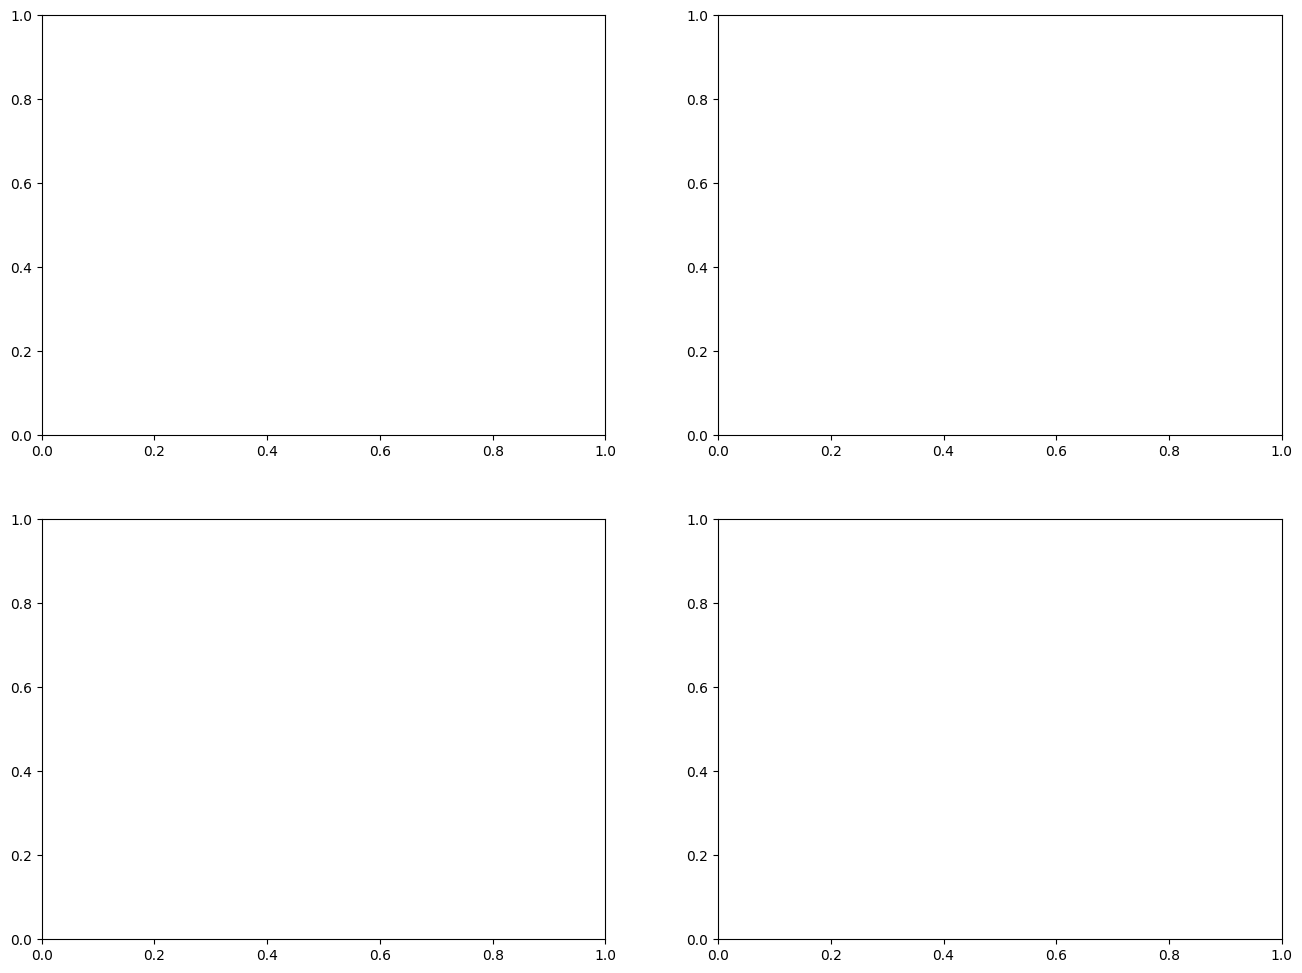

In [ ]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Z_estimate vs Brute Force (for K <= 4)
ax1 = axes[0, 0]
for K in [2, 3, 4]:
    df_k = df_results[(df_results['K'] == K) & (df_results['brute_force'].notna())]
    if len(df_k) > 0:
        ax1.scatter(df_k['brute_force'], df_k['Z_estimate'], 
                   label=f'K={K}', s=100, alpha=0.6)
# Perfect line
if len(df_results[df_results['brute_force'].notna()]) > 0:
    min_val = df_results[df_results['brute_force'].notna()]['brute_force'].min()
    max_val = df_results[df_results['brute_force'].notna()]['brute_force'].max()
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect', linewidth=2)
ax1.set_xlabel('Brute Force Count')
ax1.set_ylabel('MCMC Estimate')
ax1.set_title('Z Estimate vs Brute Force (K ≤ 4)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Relative Error vs Convergence Steps
ax2 = axes[0, 1]
for K in [2, 3, 4]:
    df_k = df_results[(df_results['K'] == K) & (df_results['relative_error'].notna())]
    if len(df_k) > 0:
        # Group by convergence_steps and average
        grouped = df_k.groupby('convergence_steps')['relative_error'].mean()
        ax2.plot(grouped.index, grouped.values, 'o-', label=f'K={K}', linewidth=2, markersize=8)
ax2.set_xlabel('Convergence Steps')
ax2.set_ylabel('Relative Error')
ax2.set_title('Relative Error vs Convergence Steps')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Relative Error vs Number of Samples
ax3 = axes[1, 0]
for K in [2, 3, 4]:
    df_k = df_results[(df_results['K'] == K) & (df_results['relative_error'].notna())]
    if len(df_k) > 0:
        # Group by num_samples and average
        grouped = df_k.groupby('num_samples')['relative_error'].mean()
        ax3.plot(grouped.index, grouped.values, 'o-', label=f'K={K}', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Samples')
ax3.set_ylabel('Relative Error')
ax3.set_title('Relative Error vs Number of Samples')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Z Estimate by K (all experiments)
ax4 = axes[1, 1]
for K in K_values:
    df_k = df_results[df_results['K'] == K]
    if len(df_k) > 0 and df_k['Z_estimate'].notna().any():
        estimates = df_k['Z_estimate'].dropna()
        ax4.scatter([K] * len(estimates), estimates, alpha=0.5, s=50, label=f'K={K}')
        if len(estimates) > 0:
            ax4.axhline(estimates.mean(), color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('K')
ax4.set_ylabel('Z Estimate')
ax4.set_title('Z Estimate Distribution by K')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hardcore_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed plots
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# Execution time vs K
ax5 = axes2[0]
for K in K_values:
    df_k = df_results[(df_results['K'] == K) & (df_results['execution_time'].notna())]
    if len(df_k) > 0:
        times = df_k['execution_time']
        ax5.scatter([K] * len(times), times, alpha=0.6, s=100, label=f'K={K}')
        if len(times) > 0:
            ax5.axhline(times.mean(), color='red', linestyle='--', alpha=0.5)
ax5.set_xlabel('K')
ax5.set_ylabel('Execution Time (seconds)')
ax5.set_title('Execution Time by K')
ax5.set_yscale('log')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Heatmap of relative error for K=2,3,4
ax6 = axes2[1]
df_small_k = df_results[(df_results['K'].isin([2, 3, 4])) & (df_results['relative_error'].notna())]
if len(df_small_k) > 0:
    # Create pivot table for heatmap
    pivot_data = df_small_k.pivot_table(
        values='relative_error',
        index='convergence_steps',
        columns='num_samples',
        aggfunc='mean'
    )
    im = ax6.imshow(pivot_data.values, aspect='auto', cmap='YlOrRd', origin='lower')
    ax6.set_xticks(range(len(pivot_data.columns)))
    ax6.set_xticklabels([f'{int(x):.0e}' for x in pivot_data.columns])
    ax6.set_yticks(range(len(pivot_data.index)))
    ax6.set_yticklabels([f'{int(x):.0e}' for x in pivot_data.index])
    ax6.set_xlabel('Number of Samples')
    ax6.set_ylabel('Convergence Steps')
    ax6.set_title('Relative Error Heatmap (K=2,3,4)')
    plt.colorbar(im, ax=ax6, label='Relative Error')

plt.tight_layout()
plt.savefig('hardcore_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
print("\nBy K value:")
print(df_results.groupby('K')[['Z_estimate', 'relative_error', 'execution_time']].agg(['mean', 'std', 'min', 'max']))

print("\n\nBy Convergence Steps:")
print(df_results.groupby('convergence_steps')[['relative_error', 'execution_time']].agg(['mean', 'std']))

print("\n\nBy Number of Samples:")
print(df_results.groupby('num_samples')[['relative_error', 'execution_time']].agg(['mean', 'std']))


In [ ]:
# Save results to CSV
df_results.to_csv('hardcore_experiment_results.csv', index=False)
print("Results saved to 'hardcore_experiment_results.csv'")

# Display full dataframe
print("\n" + "="*60)
print("Complete Results DataFrame")
print("="*60)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(df_results)
